 # Práctica 2 de Sistemas Inteligentes.

 Clasificación de imagenes fashion-MNIST mediante AdaBoost.
 
* La forma más sencilla de clasificar objetos distribuidos en un espacio es dividir el espacio en dos partes y especificar que los objetos que quedan a un lado se van a clasificar según una clase y los objetos que quedan al otro lado según la otra clase. Esto es posible realizarlo de manera muy sencilla utilizando un umbral. Los umbrales pueden ser positivos o negativos y especifican para un determinado pixel (solo uno) el rango aceptable para el mismo. 

En este Notebook se incluye el código de Adaboost y la implementación de un clasificador débil de umbral. **Se debe implementar el clasificador de débil de hiperplanos y completar la sección de experimentación**.




Incluimos las librerias necesarias para obtener la base de datos, y realizar representaciones gráficas

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import os


In [2]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Using TensorFlow backend.


Observamos el tamaño de la libreria cargada. Utilizaremos solo las primeras 4000 imágenes para coincidir con la parte básica de la práctica 2 desarrollada en java

In [3]:
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

En google colab (jupyter notebook) es muy fácil poder visualizar gráficas e imágenes. Vamos a ver el segundo elemento del conjunto de entrenamiento:

(<matplotlib.image.AxesImage at 0x7f29dc253cc0>, 0)

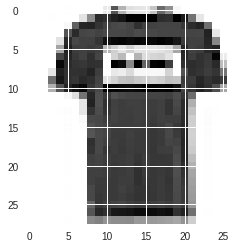

In [4]:
plt.imshow(x_train[1]),y_train[1]

# Algoritmo Adaboost
A continuación se presenta una implementación del algoritmo Adaboost

In [0]:
def adaboost(X,Y,T,random_trainer_iterations,weak_generator,weak_error):
    
    N = len(X)
    h = np.zeros([T, 3], dtype=np.double)
    alpha = np.zeros(T, dtype=np.double)
    err = np.ones(T, dtype=np.double) * np.inf
    
    #Distribución inicialmente uniforme
    D = np.ones(N, dtype=np.double)/N  
    
    for i in range(T):
        for rti in range(random_trainer_iterations):
            h_tmp = weak_generator();
            [err_tmp,y_tmp] = weak_error(h_tmp,X,Y,D)
            if(err_tmp<err[i]):
                h[i] = h_tmp
                err[i] = err_tmp
                y_t = y_tmp
            
        
        alpha[i] = 0.5 * np.log((1.0 - err[i]) / err[i])
        y_t[np.where(y_t == 0)] = -1 # y_t contiene 1 en los errores 
                                     #y -1 el los aciertos, por lo que cambiare...
        
        # .. el signo de y_t (se podria cambiar solo el de alpha)
        D = np.double(D * np.exp(-alpha[i] * -y_t))  
       
        D = D/np.sum(D)  # Normalise reassigned weights
        
    return [h,alpha]   

A continuación se presenta el clasificador fuerte que se obtendrá a partir de Adaboost

In [0]:
def strong_classify_image(classifier,weak_apply, X):
    [h,alpha] = classifier
    N = len(X)
        
    fuerte = []
    for i in range(len(alpha)):
        h_res = weak_apply(h[i],X)
        if (i==0):
            fuerte = np.double(alpha[i] * h_res)
        else:
            fuerte = fuerte + np.double(alpha[i] * h_res)
        #from IPython.core.debugger import Tracer; Tracer()()
        
    f = np.sign(fuerte)
    return f
        
    

## Definición de los clasificadores débiles como umbral para un pixel de la imagen

In [0]:
def generate_weak_threshold():
    ht = np.zeros(3)
    ht[0] = np.random.randint(28*28) #Pos. Img.
    ht[1] = np.random.rand(1)*256    #Valor
    ht[2] = np.sign(np.random.rand(1)*2-1)  #Direccion umbral
    return ht;

def apply_weak_threshold(ht,X):
    k = int(ht[0])
    if(ht[-1]>0):
        t = X[:,k]>ht[1]
    else: 
        t = X[:,k]<=ht[1]
    
    #Verifico que las condiciones se cumplan en todas las
    #dimensiones (true si cumple, false si no)
    t_all = np.int16(t)
    t_all[np.where(t_all == 0)] = -1
    
    return t_all

def error_weak_threshold(ht,X,Y,D=1):
    k = int(ht[0])
    if(ht[-1]>0):
        t = X[:,k]>ht[1]
    else: 
        t = X[:,k]<=ht[1]
        
    
    #Verifico que las condiciones se cumplan en todas las dimensiones 
    # (true si cumple, false si no)
    t_all = np.int16(t)
    t_all[np.where(t_all == 0)] = -1
    
    #Obtengo el error con respecto a Y
    errv = np.int64(t_all != Y)
    errs = np.sum(errv * D)
    
    return [errs,errv]

In [8]:
ht = generate_weak_threshold()
ht

array([178.       , 195.6687237,  -1.       ])

## Definición de los clasificadores débiles como plano
Para hacer por el alumnado

# Entrenamiento para las primeras 4000 imágenes
Obtengo un clasificador fuerte por conjunto. En esta implementación se gastan las 10 clases de la base de datos al completo (no las 8 que se gastan en la práctica de Java), con lo que los resultados pueden variar sobre esta. Es sencillo utilizar los mismos conjuntos de la implementación java si se desea...

In [15]:
num_samples = 4000
f = []
for i in range(10):
    Y = np.zeros(num_samples)
    v_digit = y_train[0:num_samples]==i
    v_else = y_train[0:num_samples]!=i
    Y[v_digit] = 1
    Y[v_else] = -1
    X = x_train[0:num_samples].reshape(num_samples,28*28)
    
    #Obtengo el clasificador fuerte para el conjunto i
    f.append(adaboost(X,Y,100,1000,generate_weak_threshold,error_weak_threshold))
    print(".")

.
.
.
.
.
.
.
.
.
.


Aplico el clasificador fuerte a todas las imágenes y obtengo el conjunto de clasificación

In [0]:
num_samples = 60000
r = []
for i in range(10):
    Y = np.zeros(num_samples)
    v_digit = y_train[0:num_samples]==i
    v_else = y_train[0:num_samples]!=i
    Y[v_digit] = 1
    Y[v_else] = -1
    X = x_train[0:num_samples].reshape(num_samples,28*28)
    r.append(strong_classify_image(f[i],apply_weak_threshold,X))

In [17]:
r_all = np.vstack([r[0],r[1],r[2],r[3],r[4],r[5],r[6],r[7],r[8],r[9]])
r_all.shape

(10, 60000)

Transformo el vector de -1 y 1 a conjunto

In [0]:
r_digits = []
for i in range(r_all.shape[1]):
    td = np.where(r_all[:,i]==1)
    if(td[0].size==0):
        rd = -1
    else:
        rd = td[0][0]
    r_digits.append(rd)

r_digits = np.asarray(r_digits)

In [19]:
r_digits

array([ 9,  0, -1, ...,  3,  0,  5])

Y obtengo la tasa de aciertos

In [20]:
Y_d = y_train[0:num_samples]
correct_digits = Y_d == r_digits
np.sum(correct_digits)/(num_samples*1.0)

0.73865

# Experimentación
Para hacer por el alumnado. Se valorará el uso de gráficas mediante *matplotlib*
## Hiperplano
### Obtener tasa de aciertos para un dígito
### Obtener tasa de aciertos para varios dígitos
## Umbral
### Obtener tasa de aciertos para un dígito
### Obtener tasa de aciertos para varios dígitos
## Comparacios hiperplano vs umbral
## Otras métricas